# ✅ CNN simple – Classification piéton vs non-piéton (fonctionnel)

In [4]:

import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import random
import matplotlib.pyplot as plt


In [5]:
# 📥 Télécharger le dataset Penn-Fudan
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

# 📂 Décompresser le fichier
!unzip PennFudanPed.zip


--2025-06-12 12:41:39--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   116MB/s    in 0.4s    

2025-06-12 12:41:39 (116 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotatio

In [6]:

class PedestrianDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        self.data = []
        all_imgs = os.listdir(img_dir)

        for img_name in all_imgs:
            path = os.path.join(img_dir, img_name)
            self.data.append((path, 1))  # piéton

            # crop négatif
            img = Image.open(path)
            w, h = img.size
            for _ in range(1):
                if w < 128 or h < 128:
                    continue
                left = random.randint(0, w - 128)
                top = random.randint(0, h - 128)
                crop = img.crop((left, top, left + 128, top + 128))
                crop_path = path + f"_crop_{left}_{top}.jpg"
                crop.save(crop_path)
                self.data.append((crop_path, 0))  # non-piéton

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)


In [7]:

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = PedestrianDataset("PennFudanPed/PNGImages", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)
print(f"Images totales : {len(dataset)} | Train : {len(train_ds)} | Val : {len(val_ds)}")


Images totales : 340 | Train : 272 | Val : 68


In [8]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16*16, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.fc(self.conv(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:

train_losses, val_accuracies = [], []

for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    val_accuracies.append(acc)
    print(f"✅ Epoch {epoch+1} terminée | Loss: {avg_loss:.4f} | Accuracy: {acc:.2%}")


✅ Epoch 1 terminée | Loss: 0.7032 | Accuracy: 72.06%
✅ Epoch 2 terminée | Loss: 0.6324 | Accuracy: 58.82%
✅ Epoch 3 terminée | Loss: 0.5767 | Accuracy: 82.35%
✅ Epoch 4 terminée | Loss: 0.4923 | Accuracy: 80.88%
✅ Epoch 5 terminée | Loss: 0.4478 | Accuracy: 94.12%


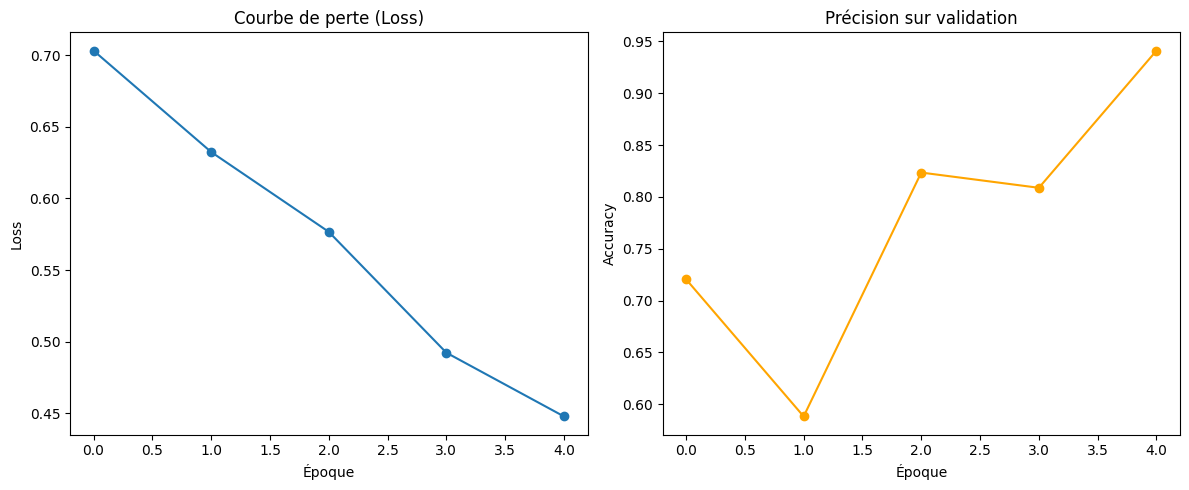

In [10]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Courbe de perte (Loss)")
plt.xlabel("Époque")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(val_accuracies, marker='o', color='orange')
plt.title("Précision sur validation")
plt.xlabel("Époque")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()
